# Simple CNN Model

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from torchsummary import summary

## Configurations

In [8]:
# Parameters
image_size = 224
batch_size = 32
num_workers = 2
learning_rate = 1e-4
num_epoch = 50
num_classes = 6  # You have 6 classes (0, 1, 2, 3, 4, 5)

In [9]:
# Data Transforms with augmentation for training
train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
])

val_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

## Define downloaded dataset path

In [10]:
# Load Dataset
data_dir = 'data'

In [11]:
train_set = torchvision.datasets.ImageFolder(root=f'{data_dir}/train', transform=train_transforms)
val_set = torchvision.datasets.ImageFolder(root=f'{data_dir}/valid', transform=val_transforms)
test_set = torchvision.datasets.ImageFolder(root=f'{data_dir}/test', transform=val_transforms)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)


## ResNet50

In [12]:
# Model: Load pre-trained ResNet50 and modify it for your dataset
resnet_model = torchvision.models.resnet50(weights='IMAGENET1K_V1').cuda()

In [13]:
# summary(resnet_model, (3, 224, 224))

In [14]:
# print(resnet_model)

In [15]:
# Freeze all layers except the last one
for param in resnet_model.parameters():
    param.requires_grad = True

In [16]:
#dropout layers to prevent the model from relying on specific neurons too much
resnet_model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(resnet_model.fc.in_features, num_classes)
)


In [17]:
# Move model to GPU
resnet_model = resnet_model.cuda()


In [18]:
# Loss function and optimizer
class_weights = torch.tensor([1/93, 1/170, 1/84, 1/84, 1/84, 1/84], dtype=torch.float).cuda()
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(resnet_model.fc.parameters(), lr=learning_rate, weight_decay=1e-3)

## Train

In [19]:
# Function to train the model
def train_model(model, train_loader, val_loader, num_epochs):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        model.train()
        train_running_loss = 0.0
        train_running_accuracy = 0.0

        for images, labels in tqdm(train_loader):
            images, labels = images.cuda(), labels.cuda()
            
            optimizer.zero_grad()

            outputs = model(images)
            loss = loss_fn(outputs, labels)

            loss.backward()
            optimizer.step()

            train_running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            train_running_accuracy += accuracy_score(labels.cpu(), preds.cpu())

        epoch_loss = train_running_loss / len(train_loader)
        epoch_acc = train_running_accuracy / len(train_loader)

        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_running_accuracy = 0.0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.cuda(), labels.cuda()

                outputs = model(images)
                loss = loss_fn(outputs, labels)

                val_running_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                val_running_accuracy += accuracy_score(labels.cpu(), preds.cpu())

        val_loss = val_running_loss / len(val_loader)
        val_acc = val_running_accuracy / len(val_loader)

        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history

In [20]:
# Function to plot training and validation loss/accuracy
def plot_training_curves(train_loss, val_loss, train_acc, val_acc):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'bo-', label='Train Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'bo-', label='Train Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Val Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

In [21]:
# Train and evaluate the model
train_loss, val_loss, train_acc, val_acc = train_model(resnet_model, train_loader, val_loader, num_epoch)

100%|██████████| 19/19 [00:43<00:00,  2.28s/it]


Epoch 1/50, Train Loss: 1.8647, Train Accuracy: 0.1625, Val Loss: 1.8107, Val Accuracy: 0.1062


100%|██████████| 19/19 [00:39<00:00,  2.09s/it]


Epoch 2/50, Train Loss: 1.8036, Train Accuracy: 0.2105, Val Loss: 1.7534, Val Accuracy: 0.2062


100%|██████████| 19/19 [00:39<00:00,  2.08s/it]


Epoch 3/50, Train Loss: 1.7527, Train Accuracy: 0.2502, Val Loss: 1.6999, Val Accuracy: 0.2687


100%|██████████| 19/19 [00:40<00:00,  2.12s/it]


Epoch 4/50, Train Loss: 1.7153, Train Accuracy: 0.2883, Val Loss: 1.6680, Val Accuracy: 0.3125


100%|██████████| 19/19 [00:39<00:00,  2.08s/it]


Epoch 5/50, Train Loss: 1.6696, Train Accuracy: 0.2864, Val Loss: 1.6131, Val Accuracy: 0.6188


100%|██████████| 19/19 [00:39<00:00,  2.10s/it]


Epoch 6/50, Train Loss: 1.6312, Train Accuracy: 0.3650, Val Loss: 1.5705, Val Accuracy: 0.6250


100%|██████████| 19/19 [00:39<00:00,  2.09s/it]


Epoch 7/50, Train Loss: 1.5963, Train Accuracy: 0.3798, Val Loss: 1.5367, Val Accuracy: 0.6750


100%|██████████| 19/19 [00:41<00:00,  2.20s/it]


Epoch 8/50, Train Loss: 1.5828, Train Accuracy: 0.3956, Val Loss: 1.4946, Val Accuracy: 0.7438


100%|██████████| 19/19 [00:41<00:00,  2.16s/it]


Epoch 9/50, Train Loss: 1.5584, Train Accuracy: 0.4232, Val Loss: 1.4627, Val Accuracy: 0.7500


100%|██████████| 19/19 [00:41<00:00,  2.20s/it]


Epoch 10/50, Train Loss: 1.5174, Train Accuracy: 0.4669, Val Loss: 1.4359, Val Accuracy: 0.7812


100%|██████████| 19/19 [00:43<00:00,  2.27s/it]


Epoch 11/50, Train Loss: 1.4676, Train Accuracy: 0.4966, Val Loss: 1.3904, Val Accuracy: 0.7250


100%|██████████| 19/19 [00:40<00:00,  2.11s/it]


Epoch 12/50, Train Loss: 1.4368, Train Accuracy: 0.5524, Val Loss: 1.3733, Val Accuracy: 0.8250


100%|██████████| 19/19 [00:40<00:00,  2.11s/it]


Epoch 13/50, Train Loss: 1.4213, Train Accuracy: 0.5380, Val Loss: 1.3389, Val Accuracy: 0.7937


100%|██████████| 19/19 [00:39<00:00,  2.10s/it]


Epoch 14/50, Train Loss: 1.3877, Train Accuracy: 0.5450, Val Loss: 1.3200, Val Accuracy: 0.8063


100%|██████████| 19/19 [00:40<00:00,  2.15s/it]


Epoch 15/50, Train Loss: 1.3448, Train Accuracy: 0.6231, Val Loss: 1.2856, Val Accuracy: 0.8250


100%|██████████| 19/19 [01:28<00:00,  4.66s/it]


Epoch 16/50, Train Loss: 1.3155, Train Accuracy: 0.6347, Val Loss: 1.2538, Val Accuracy: 0.8187


100%|██████████| 19/19 [01:10<00:00,  3.71s/it]


Epoch 17/50, Train Loss: 1.3147, Train Accuracy: 0.6288, Val Loss: 1.2287, Val Accuracy: 0.8187


100%|██████████| 19/19 [00:42<00:00,  2.24s/it]


Epoch 18/50, Train Loss: 1.3001, Train Accuracy: 0.6179, Val Loss: 1.2192, Val Accuracy: 0.8063


100%|██████████| 19/19 [00:42<00:00,  2.24s/it]


Epoch 19/50, Train Loss: 1.2616, Train Accuracy: 0.6462, Val Loss: 1.1892, Val Accuracy: 0.7937


100%|██████████| 19/19 [00:39<00:00,  2.10s/it]


Epoch 20/50, Train Loss: 1.2393, Train Accuracy: 0.6757, Val Loss: 1.1759, Val Accuracy: 0.8750


100%|██████████| 19/19 [00:41<00:00,  2.20s/it]


Epoch 21/50, Train Loss: 1.2199, Train Accuracy: 0.6791, Val Loss: 1.1268, Val Accuracy: 0.8625


100%|██████████| 19/19 [00:40<00:00,  2.12s/it]


Epoch 22/50, Train Loss: 1.2140, Train Accuracy: 0.6577, Val Loss: 1.1155, Val Accuracy: 0.8500


100%|██████████| 19/19 [00:40<00:00,  2.11s/it]


Epoch 23/50, Train Loss: 1.1861, Train Accuracy: 0.6984, Val Loss: 1.1039, Val Accuracy: 0.8750


100%|██████████| 19/19 [00:40<00:00,  2.11s/it]


Epoch 24/50, Train Loss: 1.1353, Train Accuracy: 0.7110, Val Loss: 1.0735, Val Accuracy: 0.8625


100%|██████████| 19/19 [00:40<00:00,  2.13s/it]


Epoch 25/50, Train Loss: 1.0892, Train Accuracy: 0.7432, Val Loss: 1.0656, Val Accuracy: 0.8688


100%|██████████| 19/19 [00:39<00:00,  2.09s/it]


Epoch 26/50, Train Loss: 1.0984, Train Accuracy: 0.7142, Val Loss: 1.0459, Val Accuracy: 0.8688


100%|██████████| 19/19 [00:40<00:00,  2.12s/it]


Epoch 27/50, Train Loss: 1.1028, Train Accuracy: 0.7195, Val Loss: 1.0298, Val Accuracy: 0.8562


100%|██████████| 19/19 [00:40<00:00,  2.13s/it]


Epoch 28/50, Train Loss: 1.0901, Train Accuracy: 0.7195, Val Loss: 1.0080, Val Accuracy: 0.8812


100%|██████████| 19/19 [00:40<00:00,  2.12s/it]


Epoch 29/50, Train Loss: 1.0599, Train Accuracy: 0.7445, Val Loss: 0.9949, Val Accuracy: 0.8750


100%|██████████| 19/19 [00:40<00:00,  2.13s/it]


Epoch 30/50, Train Loss: 1.0626, Train Accuracy: 0.7142, Val Loss: 0.9557, Val Accuracy: 0.9000


100%|██████████| 19/19 [00:40<00:00,  2.11s/it]


Epoch 31/50, Train Loss: 1.0433, Train Accuracy: 0.7386, Val Loss: 0.9764, Val Accuracy: 0.8938


100%|██████████| 19/19 [00:40<00:00,  2.14s/it]


Epoch 32/50, Train Loss: 1.0215, Train Accuracy: 0.7494, Val Loss: 0.9450, Val Accuracy: 0.8938


100%|██████████| 19/19 [00:40<00:00,  2.12s/it]


Epoch 33/50, Train Loss: 0.9983, Train Accuracy: 0.7560, Val Loss: 0.9359, Val Accuracy: 0.8938


100%|██████████| 19/19 [00:44<00:00,  2.33s/it]


Epoch 34/50, Train Loss: 0.9874, Train Accuracy: 0.7622, Val Loss: 0.9078, Val Accuracy: 0.9000


100%|██████████| 19/19 [00:40<00:00,  2.15s/it]


Epoch 35/50, Train Loss: 0.9569, Train Accuracy: 0.7931, Val Loss: 0.9114, Val Accuracy: 0.8875


100%|██████████| 19/19 [00:40<00:00,  2.11s/it]


Epoch 36/50, Train Loss: 0.9947, Train Accuracy: 0.7609, Val Loss: 0.8897, Val Accuracy: 0.9062


100%|██████████| 19/19 [00:40<00:00,  2.13s/it]


Epoch 37/50, Train Loss: 0.9299, Train Accuracy: 0.7787, Val Loss: 0.8883, Val Accuracy: 0.8875


100%|██████████| 19/19 [00:39<00:00,  2.09s/it]


Epoch 38/50, Train Loss: 0.9568, Train Accuracy: 0.7494, Val Loss: 0.8590, Val Accuracy: 0.9187


100%|██████████| 19/19 [00:39<00:00,  2.08s/it]


Epoch 39/50, Train Loss: 0.9303, Train Accuracy: 0.7869, Val Loss: 0.8954, Val Accuracy: 0.8938


100%|██████████| 19/19 [00:40<00:00,  2.14s/it]


Epoch 40/50, Train Loss: 0.9373, Train Accuracy: 0.7889, Val Loss: 0.8225, Val Accuracy: 0.9000


100%|██████████| 19/19 [00:39<00:00,  2.09s/it]


Epoch 41/50, Train Loss: 0.9329, Train Accuracy: 0.7702, Val Loss: 0.8558, Val Accuracy: 0.9000


100%|██████████| 19/19 [00:39<00:00,  2.10s/it]


Epoch 42/50, Train Loss: 0.8907, Train Accuracy: 0.7863, Val Loss: 0.8398, Val Accuracy: 0.9000


100%|██████████| 19/19 [00:40<00:00,  2.12s/it]


Epoch 43/50, Train Loss: 0.8841, Train Accuracy: 0.8056, Val Loss: 0.8488, Val Accuracy: 0.9125


100%|██████████| 19/19 [00:40<00:00,  2.15s/it]


Epoch 44/50, Train Loss: 0.8788, Train Accuracy: 0.7956, Val Loss: 0.8066, Val Accuracy: 0.9250


100%|██████████| 19/19 [00:40<00:00,  2.13s/it]


Epoch 45/50, Train Loss: 0.8588, Train Accuracy: 0.8241, Val Loss: 0.8347, Val Accuracy: 0.8688


100%|██████████| 19/19 [00:40<00:00,  2.15s/it]


Epoch 46/50, Train Loss: 0.8481, Train Accuracy: 0.8021, Val Loss: 0.7836, Val Accuracy: 0.9062


100%|██████████| 19/19 [00:41<00:00,  2.18s/it]


Epoch 47/50, Train Loss: 0.8621, Train Accuracy: 0.7797, Val Loss: 0.8319, Val Accuracy: 0.8812


100%|██████████| 19/19 [00:39<00:00,  2.09s/it]


Epoch 48/50, Train Loss: 0.8105, Train Accuracy: 0.8294, Val Loss: 0.7561, Val Accuracy: 0.9125


100%|██████████| 19/19 [00:40<00:00,  2.13s/it]


Epoch 49/50, Train Loss: 0.8623, Train Accuracy: 0.7951, Val Loss: 0.7630, Val Accuracy: 0.9187


100%|██████████| 19/19 [00:39<00:00,  2.10s/it]


Epoch 50/50, Train Loss: 0.8226, Train Accuracy: 0.7981, Val Loss: 0.7612, Val Accuracy: 0.9250


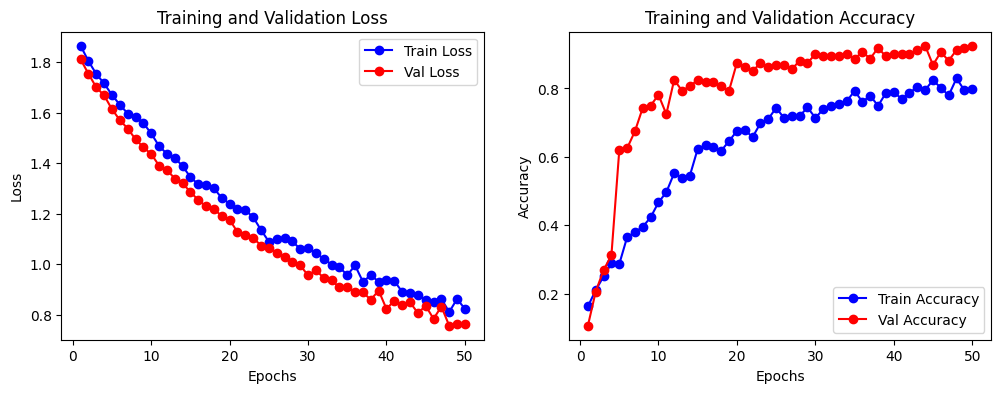

In [23]:
# Plot the training curves
plot_training_curves(train_loss, val_loss, train_acc, val_acc)

In [25]:
import os

# Save the model after training
def save_model(model, save_path='model.pth'):
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")

# After training is complete, call this to save the model
save_model(resnet_model, 'model.pth')


Model saved to model.pth
